In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import lmfit
import corner

from IPython.display import display, Markdown, Latex

In [93]:
def double_logit_function(x, a1, b1, k1, a2, b2, k2, e, __lnsigma=0):
    d1 = k1 * (b1 - np.array(x))
    g1 = a1 / (1 + np.exp(d1))
    d2 = k2 * (b2 - np.array(x))
    g2 = (a2 - a1) / (1 + np.exp(d2))
    return g1 + g2 + e

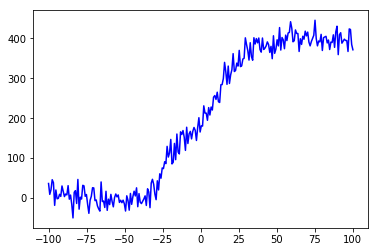

In [94]:
x = np.linspace(-100, 100, 250)
np.random.seed(0)

y = double_logit_function(
    x,
    100, -25, .5,
    400, 10, .1,
    1
) + np.random.randn(x.size) * 20
plt.plot(x, y, 'b')
plt.show()

In [147]:
p = lmfit.Parameters()
p.add_many(('a1', 200.), ('b1', -5.), ('k1', .1), ('a2', 500.), ('b2', 5.), ('k2', .1), ('e', 0.))

def residual(p):
    v = p.valuesdict()
    return double_logit_function(x, **v) - y

In [148]:
mi = lmfit.minimize(residual, p, method='nelder', nan_policy='omit')

In [149]:
list(list(mi.covar))

[array([ 1.68130974e+02,  5.62095742e+00, -1.03795711e+00, -4.12534908e+00,
         1.41732317e+01,  9.28768638e-02, -5.33311217e+00]),
 array([ 5.62095742e+00,  6.19486216e-01, -3.71400913e-02, -4.85766586e-01,
         5.02313527e-01,  2.59519125e-03,  2.68050492e-01]),
 array([-1.03795711e+00, -3.71400913e-02,  1.34842896e-02,  6.11092008e-04,
        -8.43990951e-02, -4.97171238e-04,  4.69568596e-02]),
 array([-4.12534908e+00, -4.85766586e-01,  6.11092008e-04,  1.16366784e+01,
        -1.96740639e-01, -1.15845415e-02, -5.01149626e+00]),
 array([ 1.41732317e+01,  5.02313527e-01, -8.43990951e-02, -1.96740639e-01,
         1.53001784e+00,  7.64788942e-03, -3.05038424e-02]),
 array([ 9.28768638e-02,  2.59519125e-03, -4.97171238e-04, -1.15845415e-02,
         7.64788942e-03,  8.05475037e-05,  6.61168446e-04]),
 array([-5.33311217e+00,  2.68050492e-01,  4.69568596e-02, -5.01149626e+00,
        -3.05038424e-02,  6.61168446e-04,  4.88337969e+00])]

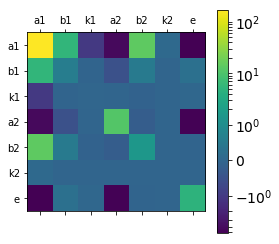

In [150]:
from matplotlib.colors import SymLogNorm
plt.matshow(mi.covar, norm=SymLogNorm(1))

groups = p

x_pos = np.arange(len(groups))
plt.xticks(x_pos, groups)

y_pos = np.arange(len(groups))
plt.yticks(y_pos, groups)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

plt.show()

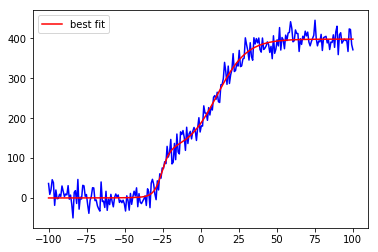

In [151]:
plt.plot(x, y, 'b')
plt.plot(x, residual(mi.params) + y, 'r', label='best fit')
plt.legend(loc='best')
plt.show()

In [152]:
mi.params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

In [153]:
res = lmfit.minimize(
    residual, method='emcee', nan_policy='omit', burn=300, steps=1000, thin=20,
    params=mi.params, is_weighted=False, progress=False
)

The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [140.11382835  30.36002234 123.35575701  68.942597   124.74552008
 111.610851   124.1459381   73.46310146]


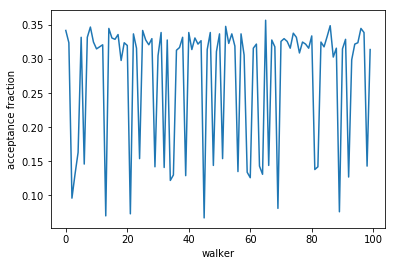

In [154]:
plt.plot(res.acceptance_fraction)
plt.xlabel('walker')
plt.ylabel('acceptance fraction')
plt.show()

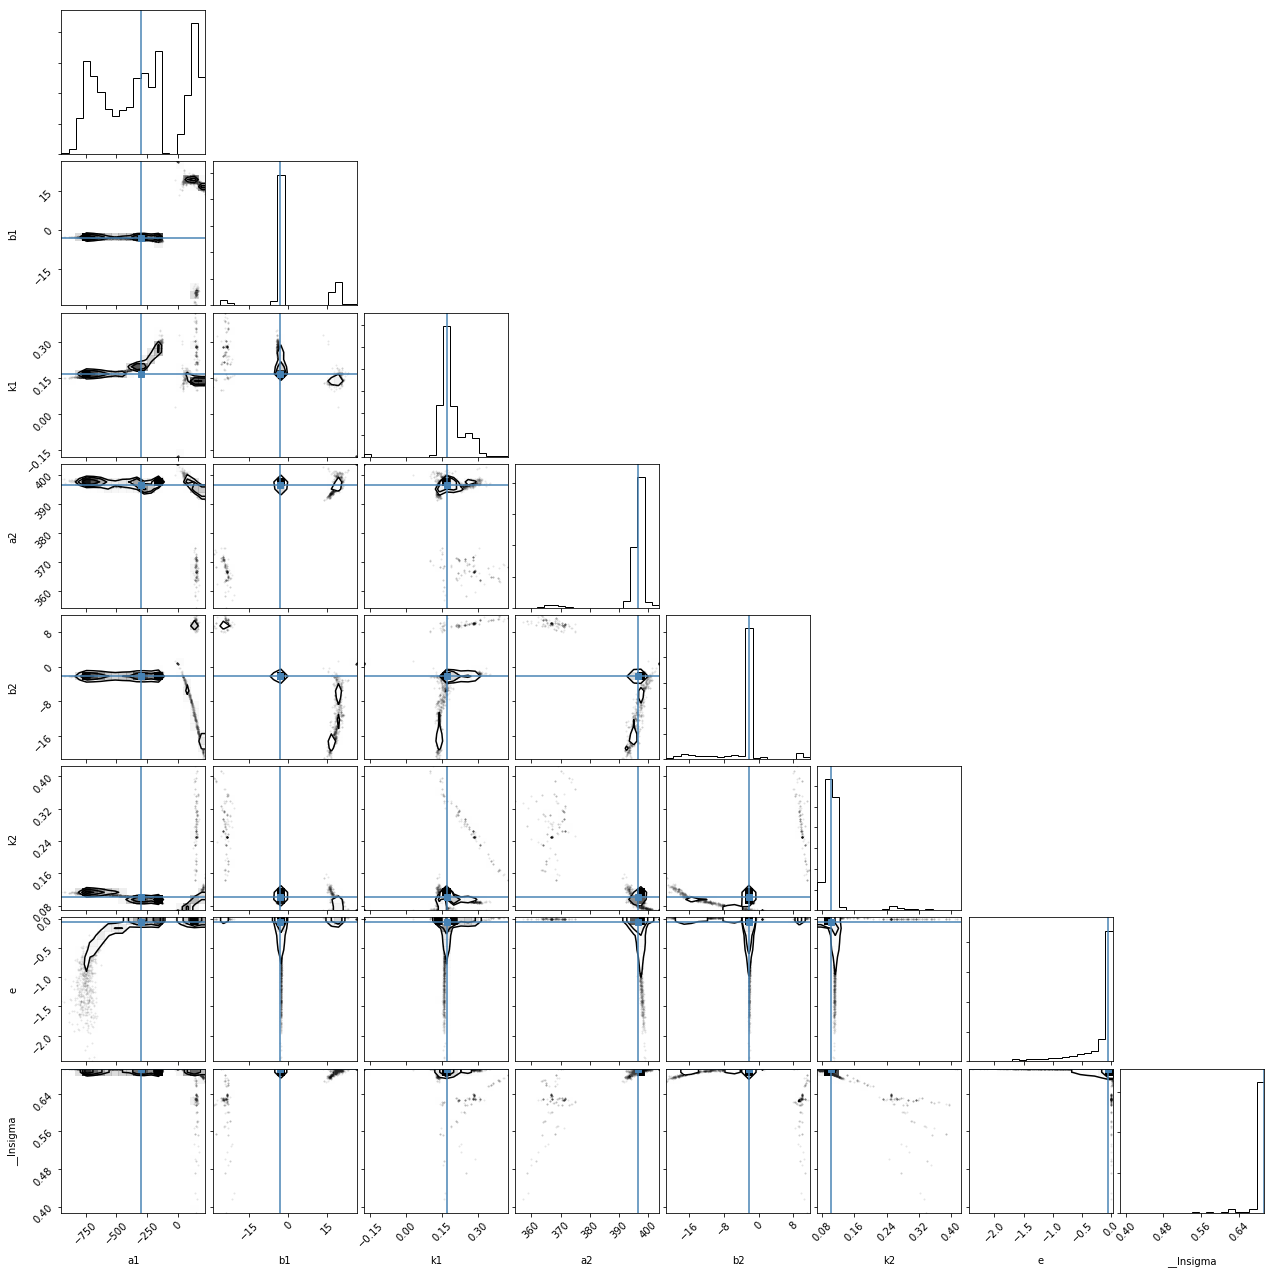

In [155]:
emcee_plot = corner.corner(
    res.flatchain, labels=res.var_names,
    truths=list(res.params.valuesdict().values())
)

(array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]),
 array([-11. , -10.1,  -9.2,  -8.3,  -7.4,  -6.5,  -5.6,  -4.7,  -3.8,
         -2.9,  -2. ]),
 array([ 3. ,  3.9,  4.8,  5.7,  6.6,  7.5,  8.4,  9.3, 10.2, 11.1, 12. ]),
 <matplotlib.collections.QuadMesh at 0x1a267acbd0>)

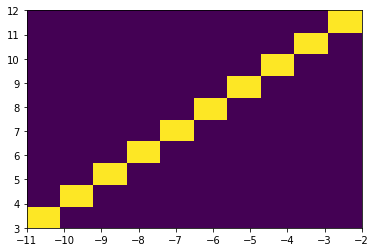

In [6]:
hx = [
    np.arange(-11, -1),
    np.arange(-14, -4)
]
hy = [
    np.arange(1, 11),
    np.arange(3, 13)
]

plt.hist2d(hx[0], hy[1])

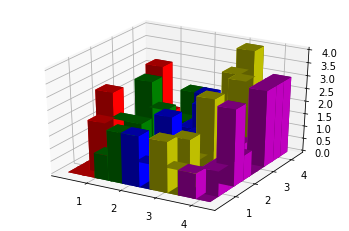

In [30]:
from mpl_toolkits.mplot3d import Axes3D

# Fixing random state for reproducibility
np.random.seed(19680801)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x, y = np.random.rand(2, 100) * 4
hist, xedges, yedges = np.histogram2d(x, y, bins=10, range=[[0, 4], [0, 4]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

colors = np.array([])
colors = np.append(colors, ["r" for _ in range(20)])
colors = np.append(colors, ["g" for _ in range(20)])
colors = np.append(colors, ["b" for _ in range(20)])
colors = np.append(colors, ["y" for _ in range(20)])
colors = np.append(colors, ["m" for _ in range(20)])

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color=colors)

plt.show()

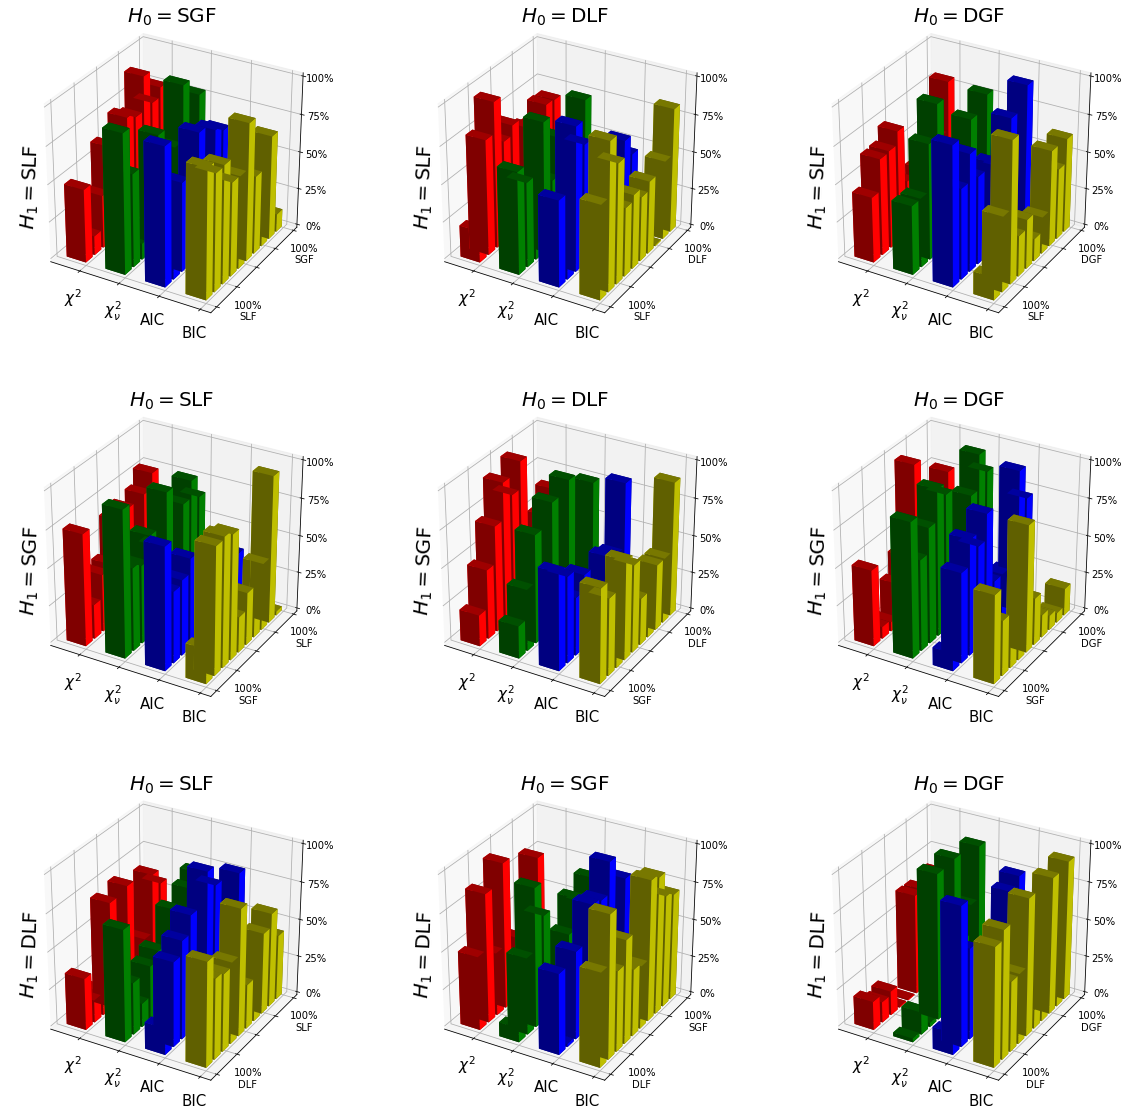

In [212]:
col_list = ["r", "g", "b", "y"]

fig = plt.figure(figsize=(20, 20))

functions = ["SLF", "SGF", "DLF", "DGF"]

ii = 0
for f1 in functions:
    if ii > 2:
        break
    jj = 0
    for f0 in functions:
        if f0 == f1:
            continue
        ax = fig.add_subplot(3, 3, ii * 3 + jj + 1, projection='3d')
        ax.set_title(f"$H_0=${f0}", pad=15, fontsize=20)
        ax.set_zlabel(f"$H_1=${f1}", labelpad=-200, rotation=90, fontsize=20)
        # 1st
        colors = []
        xpos = []
        ypos = []
        dz = []
        for i in range(4):
            for j in range(10):
                xpos.append(i)
                ypos.append(j * 10)
                dz.append(np.random.random() * 100)
                colors.append(col_list[i])

        
        b = ax.bar3d(
            xpos,  # Information Criteria
            ypos,  # Bins of density histogram
            0,     # zpos -> histograms base on z
            .5,   # dx   -> histograms size on x
            7.5,    # dy   -> histograms size on y
            dz,    # fitted density values bin reduced and ravel() together
            zsort='average',
            color=colors,
        )
        b.set_alpha(.5)
        ax.set_xticks([.5, 1.5, 2.5, 3.5])
        ax.set_xticklabels(["$\chi^2$", "$\chi^2_\\nu$", "AIC", "BIC",], fontsize=15)
        ax.set_yticks([0, 25, 50, 75, 100])
        ax.set_yticklabels(["", f"100%\n{f1}", "", "", f"100%\n{f0}"])
        ax.set_zlim(0, 100)
        ax.set_zticks([0, 25, 50, 75, 100])
        ax.set_zticklabels(["0%", "25%", "50%", "75%", "100%"])
        
        jj += 1
    ii += 1

plt.show()

In [ ]:
from matplotlib import rc
rc('text',usetex=True)
#rc('text.latex', preamble=r"\usepackage{xcolor}")

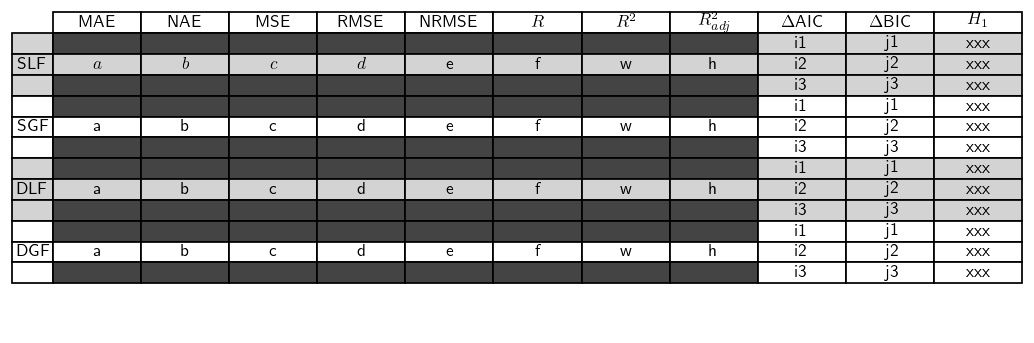

In [12]:
fig, ax = plt.subplots(figsize=(10, .5), dpi=125)
plt.axis('tight')
plt.axis("off")
ax.table(
    cellText=[
        ["", "", "", "", "", "", "", "", "i1", "j1", "xxx"],
        ["$a$", "$b$", "$c$", "$d$", "e", "f", "w", "h", "i2", "j2", "xxx"],
        ["", "", "", "", "", "", "", "", "i3", "j3", "xxx"],
        
        ["", "", "", "", "", "", "", "", "i1", "j1", "xxx"],
        ["a", "b", "c", "d", "e", "f", "w", "h", "i2", "j2", "xxx"],
        ["", "", "", "", "", "", "", "", "i3", "j3", "xxx"],
        
        ["", "", "", "", "", "", "", "", "i1", "j1", "xxx"],
        ["a", "b", "c", "d", "e", "f", "w", "h", "i2", "j2", "xxx"],
        ["", "", "", "", "", "", "", "", "i3", "j3", "xxx"],
        
        ["", "", "", "", "", "", "", "", "i1", "j1", "xxx"],
        ["a", "b", "c", "d", "e", "f", "w", "h", "i2", "j2", "xxx"],
        ["", "", "", "", "", "", "", "", "i3", "j3", "xxx"],
    ],
    cellColours=[
        ["#444444", "#444444", "#444444", "#444444", "#444444", "#444444", "#444444", "#444444", "lightgrey", "lightgrey", "lightgrey"],
        ["lightgrey", "lightgrey", "lightgrey", "lightgrey", "lightgrey", "lightgrey", "lightgrey", "lightgrey", "lightgrey", "lightgrey", "lightgrey"],
        ["#444444", "#444444", "#444444", "#444444", "#444444", "#444444", "#444444", "#444444", "lightgrey", "lightgrey", "lightgrey"],
        
        ["#444444", "#444444", "#444444", "#444444", "#444444", "#444444", "#444444", "#444444", "w", "w", "w"],
        ["w", "w", "w", "w", "w", "w", "w", "w", "w", "w", "w"],
        ["#444444", "#444444", "#444444", "#444444", "#444444", "#444444", "#444444", "#444444", "w", "w", "w"],
        
        ["#444444", "#444444", "#444444", "#444444", "#444444", "#444444", "#444444", "#444444", "lightgrey", "lightgrey", "lightgrey"],
        ["lightgrey", "lightgrey", "lightgrey", "lightgrey", "lightgrey", "lightgrey", "lightgrey", "lightgrey", "lightgrey", "lightgrey", "lightgrey"],
        ["#444444", "#444444", "#444444", "#444444", "#444444", "#444444", "#444444", "#444444", "lightgrey", "lightgrey", "lightgrey"],
        
        ["#444444", "#444444", "#444444", "#444444", "#444444", "#444444", "#444444", "#444444", "w", "w", "w"],
        ["w", "w", "w", "w", "w", "w", "w", "w", "w", "w", "w"],
        ["#444444", "#444444", "#444444", "#444444", "#444444", "#444444", "#444444", "#444444", "w", "w", "w"],
    ], 
    cellLoc='center', 
    colWidths=None,
    rowLabels=[
        "", "SLF", "",
        "", "SGF", "",
        "", "DLF", "",
        "", "DGF", "",
    ],
    rowColours=[
        "lightgrey", "lightgrey", "lightgrey",
        "w", "w", "w",
        "lightgrey", "lightgrey", "lightgrey",
        "w", "w", "w",
    ],
    rowLoc='left',
    colLabels=["MAE", "NAE", "MSE", "RMSE", "NRMSE", "$R$", "$R^2$", "$R^2_{adj}$", "$\Delta$AIC", "$\Delta$BIC", "$H_1$"],
    colColours=None,
    colLoc='center',
    loc='top',
    bbox=None,
    edges='closed',
)

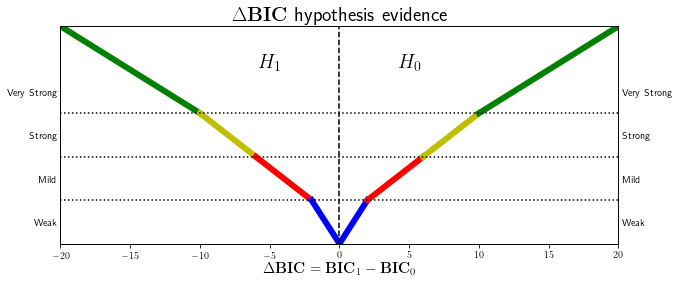

In [101]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(
    [-10, -20],
    [3, 5],
    color="g", lw=6
)
ax.plot(
    [-6, -10],
    [2, 3],
    color="y", lw=6
)
ax.plot(
    [-2, -6],
    [1, 2],
    color="r", lw=6
)
ax.plot(
    [0, -2],
    [0, 1],
    color="b", lw=6
)

ax.plot(
    [0, 2],
    [0, 1],
    color="b", lw=6
)
ax.plot(
    [2, 6],
    [1, 2],
    color="r", lw=6
)
ax.plot(
    [6, 10],
    [2, 3],
    color="y", lw=6
)
ax.plot(
    [10, 20],
    [3, 5],
    color="g", lw=6
)

ax.set_yticks([.5, 1.5, 2.5, 3.5])
ax.set_yticklabels(["Weak", "Mild", "Strong", "Very Strong"])
ax2 = plt.twinx()
ax2.set_ylim(0, 5)
ax2.set_yticks([.5, 1.5, 2.5, 3.5])
ax2.set_yticklabels(["Weak", "Mild", "Strong", "Very Strong"], )
ax.tick_params("y", length=0)
ax2.tick_params("y", length=0)

for y in [1, 2, 3]:
    ax.axhline(y, ls=":", c="k")
ax.axvline(0, ls="--", c="k")

ax.set_xlim(-20, 20)
ax.set_ylim(0, 5)

ax.set_xlabel("$\Delta\mathbf{BIC} = \mathbf{BIC}_1 - \mathbf{BIC}_0$", fontsize=15)
ax.text(5, 4, "$H_0$", fontsize=20, ha="center")
ax.text(-5, 4, "$H_1$", fontsize=20, ha="center")
ax.set_title("$\Delta\mathbf{BIC}$ hypothesis evidence", fontsize=20)
plt.show()

In [69]:
from scipy import stats as sts
from scipy.optimize import curve_fit
import sklearn.metrics as skl

In [128]:
def distribution(diff):
    try:
        return np.exp(-.5 * diff) / (1 + np.exp(-.5 * diff))
    except Exception as err:
        if diff > 0:
            return 1.
        return 0.

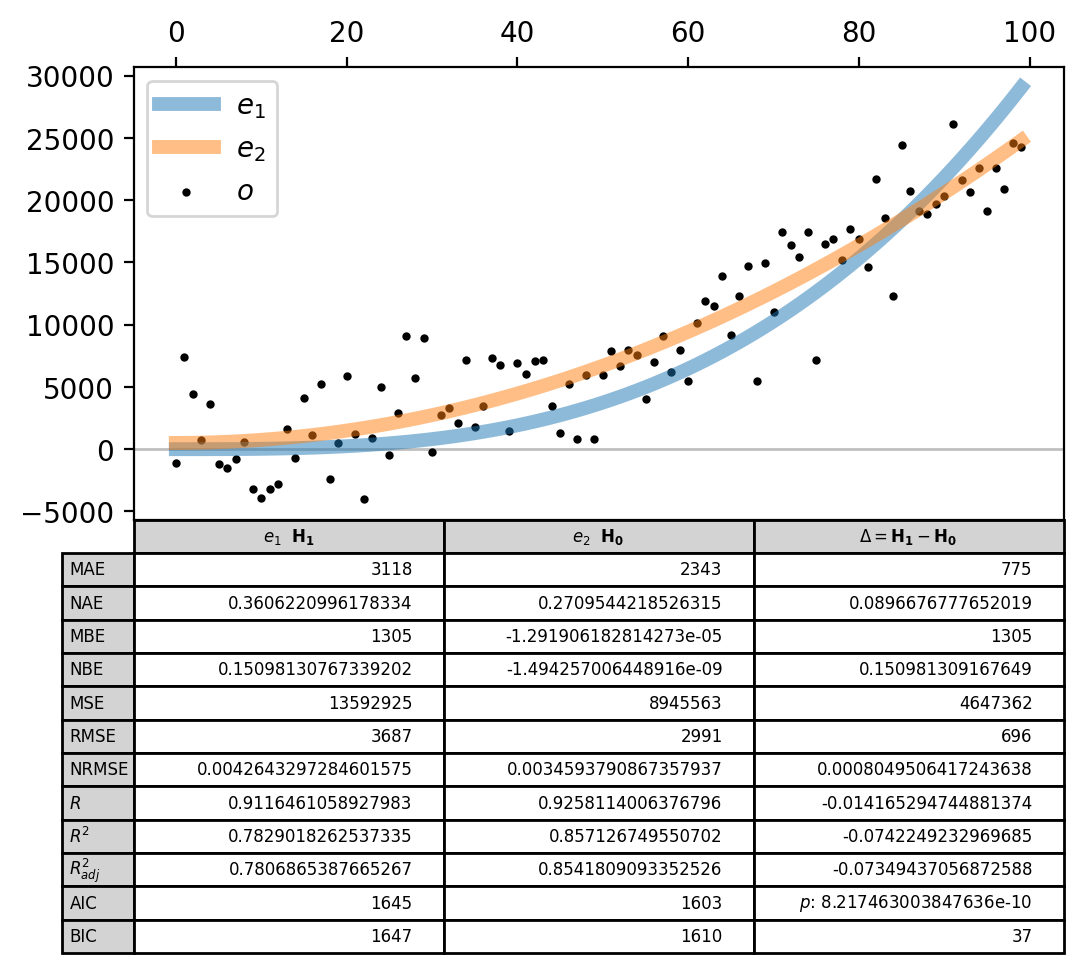

In [42]:
import numpy as np
from scipy import stats as sts
from scipy.optimize import curve_fit
import sklearn.metrics as skl
from matplotlib import pyplot as plt

def AIC_test(diff):
    try:
        return np.exp(-.5 * diff) / (1 + np.exp(-.5 * diff))
    except Exception as err:
        if diff > 0:
            return 1.
        return 0.

def func_noise(x, a, b, err=False):
    noise = np.random.normal(0, 3e3, len(x))
    return a * np.array(x) ** 2 + b + (noise if err else 0)

def func(x, a):
    return a * np.array(x) ** 3

def func2(x, a, b):
    return a * np.array(x) ** 2 + b

def report(o, E, P):
    cellText = []
    mae, nae, mbe, nbe, mse, rmse, nrmse, r, r2, r2a, aic, bic = (
        [] for _ in range(12)
    )
    for i, e in enumerate(E):
        mae.append(skl.mean_absolute_error(o, e))
        nae.append(np.sum(np.abs(o - e)) / np.sum(o))
        mbe.append(np.sum(o - e) / len(x))
        nbe.append(np.sum(o - e) / np.sum(o))
        _mse = skl.mean_squared_error(o, e)
        mse.append(_mse)
        _rmse = np.sqrt(_mse)
        rmse.append(_rmse)
        _nrmse = _rmse / np.sum(o)
        nrmse.append(_nrmse)
        r.append(sts.pearsonr(o, e)[0])
        r2.append(skl.r2_score(o, e))
        rss = np.sum(np.abs(o - e) ** 2)
        tss = np.sum(np.abs(o - np.mean(o)) ** 2)
        r2a.append(1 - (rss / tss) * ((len(x) - 1) / (len(x) - P[i] - 1)))
        aic.append(len(x) * np.log(rss / len(x)) + 2 * 1)
        bic.append(len(x) * np.log(rss / len(x)) + np.log(len(x)) * P[i])
    cellText.append([f"{mae[0]:.0f}", f"{mae[1]:.0f}", f"{(mae[0]-mae[1]):.0f}"])
    cellText.append([f"{nae[0]}", f"{nae[1]}", f"{(nae[0]-nae[1])}"])
    cellText.append([f"{mbe[0]:.0f}", f"{mbe[1]}", f"{(mbe[0]-mbe[1]):.0f}"])
    cellText.append([f"{nbe[0]}", f"{nbe[1]}", f"{(nbe[0]-nbe[1])}"])
    cellText.append([f"{mse[0]:.0f}", f"{mse[1]:.0f}", f"{(mse[0]-mse[1]):.0f}"])
    cellText.append([f"{rmse[0]:.0f}", f"{rmse[1]:.0f}", f"{(rmse[0]-rmse[1]):.0f}"])
    cellText.append([f"{nrmse[0]}", f"{nrmse[1]}", f"{(nrmse[0]-nrmse[1])}"])
    cellText.append([f"{r[0]}", f"{r[1]}", f"{(r[0]-r[1])}"])
    cellText.append([f"{r2[0]}", f"{r2[1]}", f"{(r2[0]-r2[1])}"])
    cellText.append([f"{r2a[0]}", f"{r2a[1]}", f"{(r2a[0]-r2a[1])}"])
    cellText.append([f"{aic[0]:.0f}", f"{aic[1]:.0f}", f"$p$: {AIC_test(aic[0]-aic[1])}"])
    cellText.append([f"{bic[0]:.0f}", f"{bic[1]:.0f}", f"{bic[0] - bic[1]:.0f}"])
    return cellText

x = np.arange(0, 100)
o = func_noise(x, 2.3, 1e3, err=True)
popt, pcov = curve_fit(func, x, o)
e1 = func(x, *popt)
popt, pcov = curve_fit(func2, x, o)
e2 = func2(x, *popt)

cellText = report(o, [e1, e2], [1, 2])

fig, ax = plt.subplots(figsize=(6, 3), dpi=200)
ax.xaxis.tick_top()
ax.axhline(0, lw=1, alpha=.25, c="k")
ax.plot(x, e1, label="$e_1$", lw=5, alpha=.5)
ax.plot(x, e2, label="$e_2$", lw=5, alpha=.5)
ax.scatter(x, o, label="$o$", s=4, c="k")
ax.legend(loc="best")
ax.table(
    cellText=cellText,
    colLabels=[
        "$e_1$  $\mathbf{H_1}$", "$e_2$  $\mathbf{H_0}$",
        "$\Delta = \mathbf{H_1} - \mathbf{H_0}$"
    ],
    colColours=["lightgrey", "lightgrey", "lightgrey"],
    rowColours=["lightgrey" for _ in range(12)],
    rowLabels=[
        "MAE", "NAE", "MBE", "NBE", "MSE", "RMSE", "NRMSE",
        "$R$",  "$R^2$", "$R^2_{adj}$", "AIC", "BIC"
    ],
)
plt.show()

In [10]:
print(r"""
\begin{table}[h!]
  \begin{center}
    \caption{Your first table.}
    \label{tab:table1}
    \begin{tabular}{l|c|r} % <-- Alignments: 1st column left, 2nd middle and 3rd right, with vertical lines in between
      \textbf{Value 1} & \textbf{Value 2} & \textbf{Value 3}\\
      $\alpha$ & $\beta$ & $\gamma$ \\
      \hline
      1 & 1110.1 & a\\
      2 & 10.1 & b\\
      3 & 23.113231 & c\\
    \end{tabular}
  \end{center}
\end{table}
    """
)


\begin{table}[h!]
  \begin{center}
    \caption{Your first table.}
    \label{tab:table1}
    \begin{tabular}{l|c|r} % <-- Alignments: 1st column left, 2nd middle and 3rd right, with vertical lines in between
      \textbf{Value 1} & \textbf{Value 2} & \textbf{Value 3}\\
      $\alpha$ & $\beta$ & $\gamma$ \\
      \hline
      1 & 1110.1 & a\\
      2 & 10.1 & b\\
      3 & 23.113231 & c\\
    \end{tabular}
  \end{center}
\end{table}
    


In [23]:
%%latex
\begin{table}[h!]
\begin{center}
\caption{Your first table.}
\label{tab:table1}
\begin{tabular}{l|c|r}
\textbf{Value 1} & \textbf{Value 2} & \textbf{Value 3} \\
\end{tabular}
\end{center}
\end{table}

<IPython.core.display.Latex object>

In [24]:
df = pd.DataFrame({"a": [1, 2], "b": [3, 4]})

In [29]:
display(Latex(df.to_latex(index=False)))

<IPython.core.display.Latex object>

In [30]:
df

,a,b
0,1,3
1,2,4


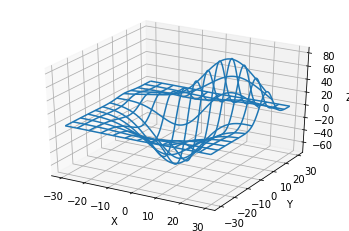

In [19]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
X, Y, Z = axes3d.get_test_data(0.05)

# Plot a basic wireframe.
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

In [20]:
X

array([[-30. , -29.5, -29. , ...,  28.5,  29. ,  29.5],
       [-30. , -29.5, -29. , ...,  28.5,  29. ,  29.5],
       [-30. , -29.5, -29. , ...,  28.5,  29. ,  29.5],
       ...,
       [-30. , -29.5, -29. , ...,  28.5,  29. ,  29.5],
       [-30. , -29.5, -29. , ...,  28.5,  29. ,  29.5],
       [-30. , -29.5, -29. , ...,  28.5,  29. ,  29.5]])

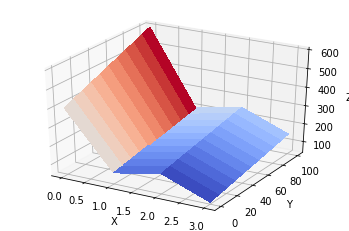

In [74]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
X = np.array([
    [0 for _ in range(11)],
    [1 for _ in range(11)],
    [2 for _ in range(11)],
    [3 for _ in range(11)],
])
Y = np.array([
    np.arange(0, 101, 10),
    np.arange(0, 101, 10),
    np.arange(0, 101, 10),
    np.arange(0, 101, 10),
])
Z = np.array([
    np.arange(400, 601, 20),
    np.arange(100, 201, 10),
    np.arange(150, 251, 10),
    np.arange(50, 151, 10),
])

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

In [56]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
X = np.array([
    [i for _ in range(1201)] for i in range(1201)
])
Y = np.array([
    process_matrix_df.columns for _ in range(process_matrix_df.index.size)
])
Z = np.array([
    process_matrix_df.loc[i] for i in range(process_matrix_df.index.size)
])

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100])